# Levenshtein distance between synthetic data and student programs

The purpose of this notebook is to compute the edit distance between the synthetic data generated by our grammars and the original student programs. Synthetic data is used to train the neural network, which is then evaluated on student programs. 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('..')

In [64]:
from autoplan.trainer import ClassifierTrainer
from autoplan.dataset import PrelabeledDataset, build_synthetic_dataset, build_prelabeled_dataset
from autoplan.generator import ProgramGenerator
from autoplan.vis import plot_accuracy, plot_cm, plot_loss
from autoplan.token import TokenType, PyretTokenizer, OCamlTokenizer
from scripts.rainfall_ingest import ingest_dataset

from grammars.rainfall.ocaml import Program
from grammars.rainfall.labels import GeneralRainfallLabels

from tqdm import tqdm_notebook as tqdm
import pandas as pd
import torch
import os
import numpy as np
import torch.nn as nn
from pprint import pprint
import nltk
# import matplotlib.pyplot as plt
# import seaborn as sns

device = torch.device('cpu')
# device = torch.device('cuda:0')
REPO_DIR = os.path.expanduser('~/autoplan')

# Student dataset

In

In [4]:
# We specify the student dataset (OCaml solutions) 
dataset_name = 'T1'
student_dataset = ingest_dataset(dataset_name, preprocess=True, exclude=[TokenType.String])

In [5]:
print(student_dataset.dataset[0]['source'])

let rec rainfall (alof : float list) =
  (let rec sum_helper (alof : float list) (sum : float) (counter : float) =
     (match (alof, counter) with
      | ([],0.) -> failwith "Empty list."
      | ((-999.)::_,0.) -> failwith "Empty list."
      | ([],_) -> (sum, counter)
      | ((-999.)::_,_) -> (sum, counter)
      | (hd::tl,_) ->
          if hd >= 0.
          then sum_helper tl (sum +. hd) (counter +. 1.)
          else sum_helper tl sum counter : (float* float)) in
   match sum_helper alof 0. 0. with | (s,c) -> s /. c : float)



# Synthetic dataset

In

In [69]:
N_samples = 100
synthetic_dataset = build_synthetic_dataset(
    GeneralRainfallLabels,
    N=N_samples,
    tokenizer=OCamlTokenizer(),
    generator=ProgramGenerator(grammar=Program(), adaptive=True),
    vocab_index=student_dataset.vocab_index,
    unique=False)

Generating programs...
Generated 88 unique programs.
Tokenizing programs...
Building dataset metadata...


In [82]:
print(synthetic_dataset.dataset[1]['source'])

let helper_name (list_name : float list) (addition_var : float)
  (counter_var : float) =
  (match list_name with
   | [] -> addition_var /. counter_var
   | head::tail when head = (-999) -> addition_var /. counter_var
   | head::tail -> helper_name tail (head + addition_var) (counter_var + 1) : 
  float)
let rainfall (list_name : float list) =
  (match list_name with
   | [] -> failwith "no rainfall value could be calculated"
   | _ -> helper_name list_name 0. 0. : float)



# Model

In

In [48]:
model_options = {
    'model' : nn.GRU,
    'hidden_size' : 512,
    'embedding_size' : 512
}

trainer = ClassifierTrainer(synthetic_dataset, device, model_options)

In [49]:
losses = []
train_eval = []
val_eval = []

for _ in tqdm(range(50)):
    losses.append(trainer.train_one_epoch())
    train, val = trainer.eval()
    train_eval.append(train)
    val_eval.append(val)

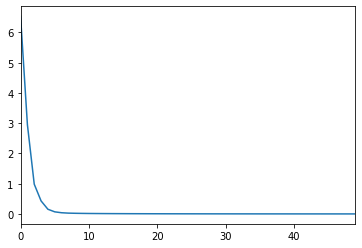

In [50]:
pd.Series(losses).plot()

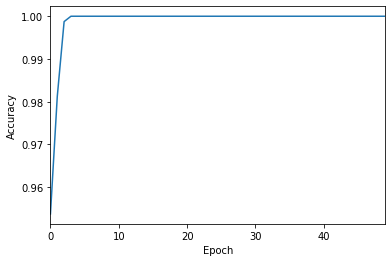

In [51]:
plot_accuracy(train_eval)

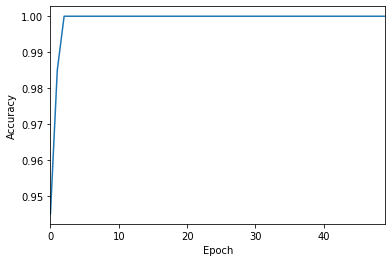

In [52]:
plot_accuracy(val_eval)

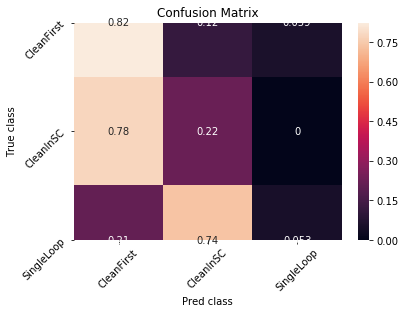

In [53]:
trainer.model.eval()
trainer.eval_on(student_dataset.loader(student_dataset.dataset)).plot_cm("Confusion Matrix", normalize=True)

# Levenshtein Distance

In [98]:
# At the string level:

N=N_samples
edit_distance = {}

for i in range(len(student_dataset.dataset)):
    print("Analyzing student answer #", i)
    student_answer = student_dataset.dataset[i]['source']
    
    min_distance = 10000 # arbitrarily large value
    for j in range(N):
        synthetic_program = synthetic_dataset.dataset[j]['source']
        levenshtein_distance = nltk.edit_distance(student_answer, synthetic_program, transpositions=False)
        if levenshtein_distance < min_distance:
            min_distance = levenshtein_distance
            nearest_program = synthetic_program
    
    edit_distance[student_answer] = [nearest_program, min_distance]
    
    if i == len(student_dataset.dataset) - 1:
        print("Done!")

Analyzing student answer # 0
Analyzing student answer # 1
Analyzing student answer # 2
Analyzing student answer # 3
Analyzing student answer # 4
Analyzing student answer # 5
Analyzing student answer # 6
Analyzing student answer # 7
Analyzing student answer # 8
Analyzing student answer # 9
Analyzing student answer # 10
Analyzing student answer # 11
Analyzing student answer # 12
Analyzing student answer # 13
Analyzing student answer # 14
Analyzing student answer # 15
Analyzing student answer # 16
Analyzing student answer # 17
Analyzing student answer # 18
Analyzing student answer # 19
Analyzing student answer # 20
Analyzing student answer # 21
Analyzing student answer # 22
Analyzing student answer # 23
Analyzing student answer # 24
Analyzing student answer # 25
Analyzing student answer # 26
Analyzing student answer # 27
Analyzing student answer # 28
Analyzing student answer # 29
Analyzing student answer # 30
Analyzing student answer # 31
Analyzing student answer # 32
Analyzing student an

In [99]:
for i in edit_distance:
    print("Synthetic program:")
    pprint(edit_distance[i])
    print("Nearest student solution:", i, "\n")

Synthetic program:
['let rainfall (list_name : float list) =\n'
 '  (let helper_name (list_name : float list) (addition_var : float)\n'
 '     (counter_var : float) =\n'
 '     (match list_name with\n'
 '      | [] -> addition_var /. counter_var\n'
 '      | head::tail when head = (-999) -> addition_var /. counter_var\n'
 '      | head::tail ->\n'
 '          if head >= 0.\n'
 '          then helper_name tail (head + addition_var) (counter_var + 1)\n'
 '          else helper_name tail addition_var counter_var : float) in\n'
 '   helper_name list_name 0. 0. : float)\n',
 301]
Nearest student solution: let rec rainfall (alof : float list) =
  (let rec sum_helper (alof : float list) (sum : float) (counter : float) =
     (match (alof, counter) with
      | ([],0.) -> failwith "Empty list."
      | ((-999.)::_,0.) -> failwith "Empty list."
      | ([],_) -> (sum, counter)
      | ((-999.)::_,_) -> (sum, counter)
      | (hd::tl,_) ->
          if hd >= 0.
          then sum_helper tl (sum 

In [100]:
# At the token level:

N=N_samples
edit_distance = {}

for i in range(len(student_dataset.dataset)):
    print("Analyzing student answer #", i)
    student_answer = student_dataset.dataset[i]['source']
    student_tokens = student_dataset.dataset[i]['program']
    
    min_distance = 10000 # arbitrarily large value
    for j in range(N):
        synthetic_program = synthetic_dataset.dataset[j]['source']
        synthetic_tokens = synthetic_dataset.dataset[j]['program']
        
        levenshtein_distance = nltk.edit_distance(student_tokens, synthetic_tokens, transpositions=False)
        if levenshtein_distance < min_distance:
            min_distance = levenshtein_distance
            nearest_program = synthetic_program
    
    edit_distance[student_answer] = [nearest_program, min_distance]
    
    if i == len(student_dataset.dataset) - 1:
        print("Done!")

Analyzing student answer # 0
Analyzing student answer # 1
Analyzing student answer # 2
Analyzing student answer # 3
Analyzing student answer # 4
Analyzing student answer # 5
Analyzing student answer # 6
Analyzing student answer # 7
Analyzing student answer # 8
Analyzing student answer # 9
Analyzing student answer # 10
Analyzing student answer # 11
Analyzing student answer # 12
Analyzing student answer # 13
Analyzing student answer # 14
Analyzing student answer # 15
Analyzing student answer # 16
Analyzing student answer # 17
Analyzing student answer # 18
Analyzing student answer # 19
Analyzing student answer # 20
Analyzing student answer # 21
Analyzing student answer # 22
Analyzing student answer # 23
Analyzing student answer # 24
Analyzing student answer # 25
Analyzing student answer # 26
Analyzing student answer # 27
Analyzing student answer # 28
Analyzing student answer # 29
Analyzing student answer # 30
Analyzing student answer # 31
Analyzing student answer # 32
Analyzing student an

In [101]:
for i in edit_distance:
    print("Synthetic program:")
    pprint(edit_distance[i])
    print("Nearest student solution:", i, "\n")

Synthetic program:
['let rainfall (list_name : float list) =\n'
 '  (let helper_name (list_name : float list) (addition_var : float)\n'
 '     (counter_var : float) =\n'
 '     (match list_name with\n'
 '      | [] -> addition_var /. counter_var\n'
 '      | head::tail when head = (-999) -> addition_var /. counter_var\n'
 '      | head::tail ->\n'
 '          if head >= 0.\n'
 '          then helper_name tail (head + addition_var) (counter_var + 1)\n'
 '          else helper_name tail addition_var counter_var : float) in\n'
 '   helper_name list_name 0. 0. : float)\n',
 103]
Nearest student solution: let rec rainfall (alof : float list) =
  (let rec sum_helper (alof : float list) (sum : float) (counter : float) =
     (match (alof, counter) with
      | ([],0.) -> failwith "Empty list."
      | ((-999.)::_,0.) -> failwith "Empty list."
      | ([],_) -> (sum, counter)
      | ((-999.)::_,_) -> (sum, counter)
      | (hd::tl,_) ->
          if hd >= 0.
          then sum_helper tl (sum 